# Импорты и кастомные функции

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Artyom\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axis', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        #как будет замечено, 1293 - это расстояние между слайсами по Z
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

# Загрузка данных

In [65]:
train = pd.read_hdf('hdf5-3/open30.h5')
test = pd.concat([pd.read_hdf(file) for file in ['test_close0.h5',
                                                 'test_close10.h5']])

In [86]:
test = test.reset_index(drop=True)

In [71]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [5]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


Посмотрим как выглядят ливни внутри одного data_ind

In [6]:
first = train.loc[train.data_ind == 21, :]

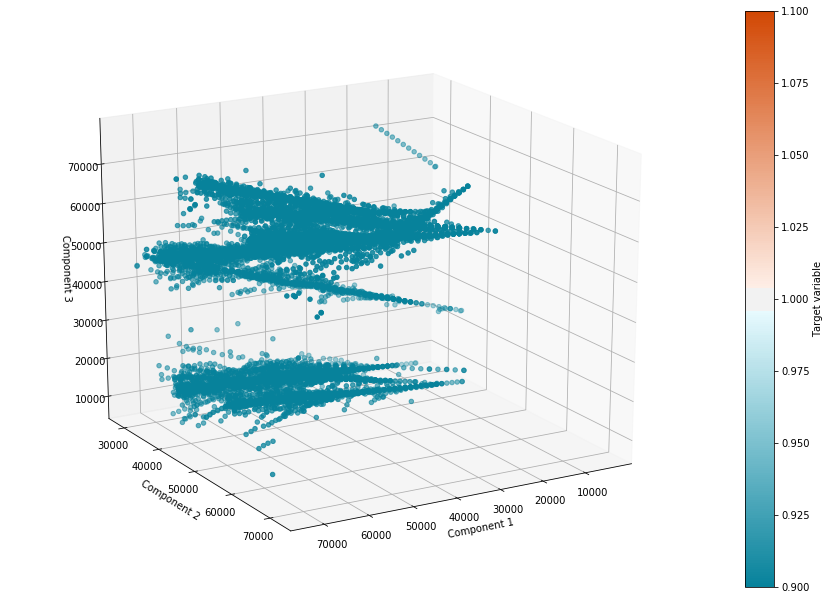

In [7]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=20, azim=60)

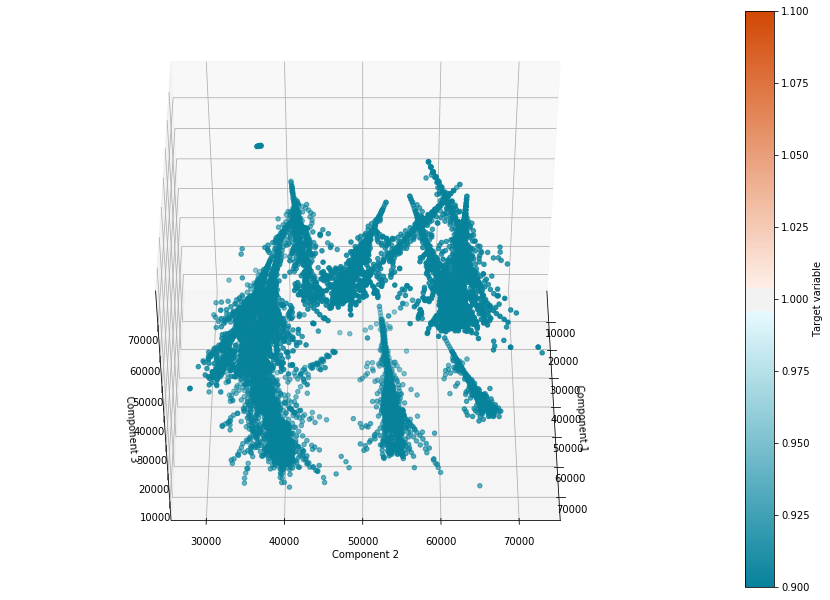

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

Глянем как распределены шум и сигнал вдоль осей

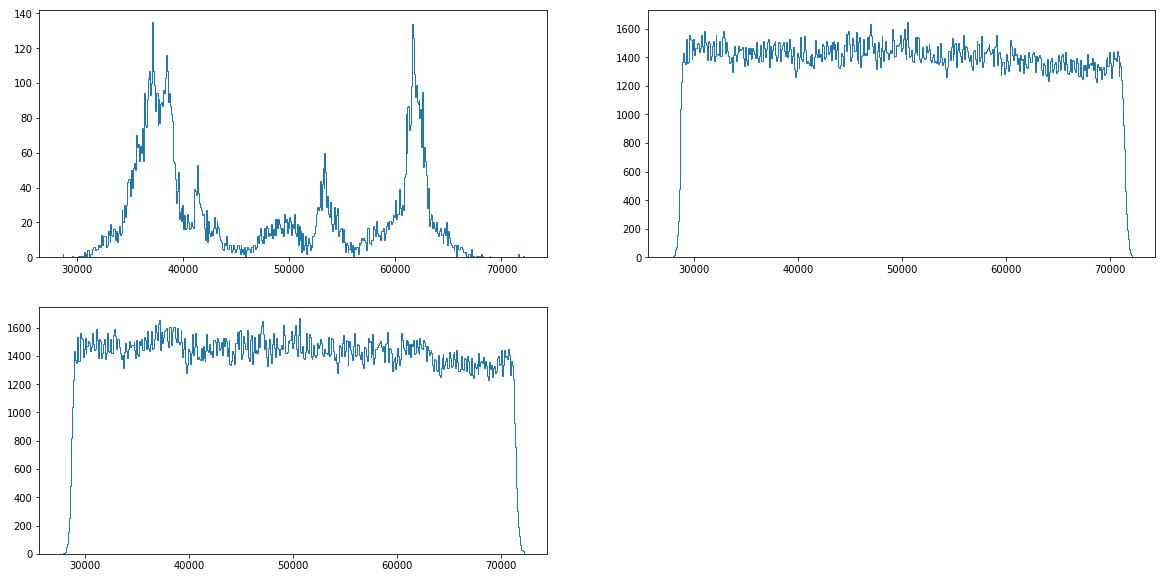

In [9]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

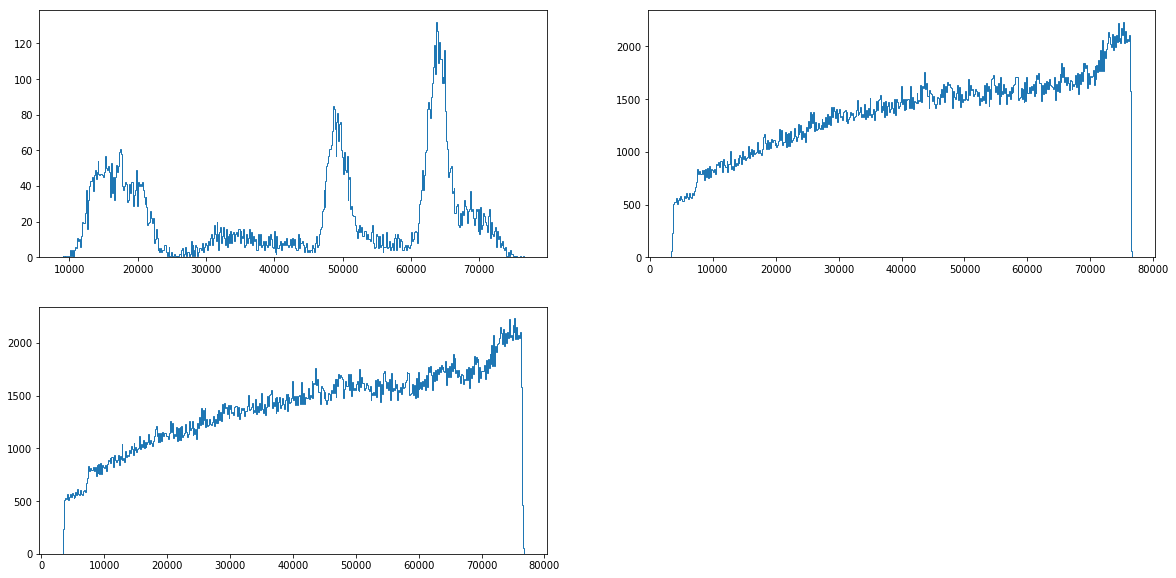

In [10]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

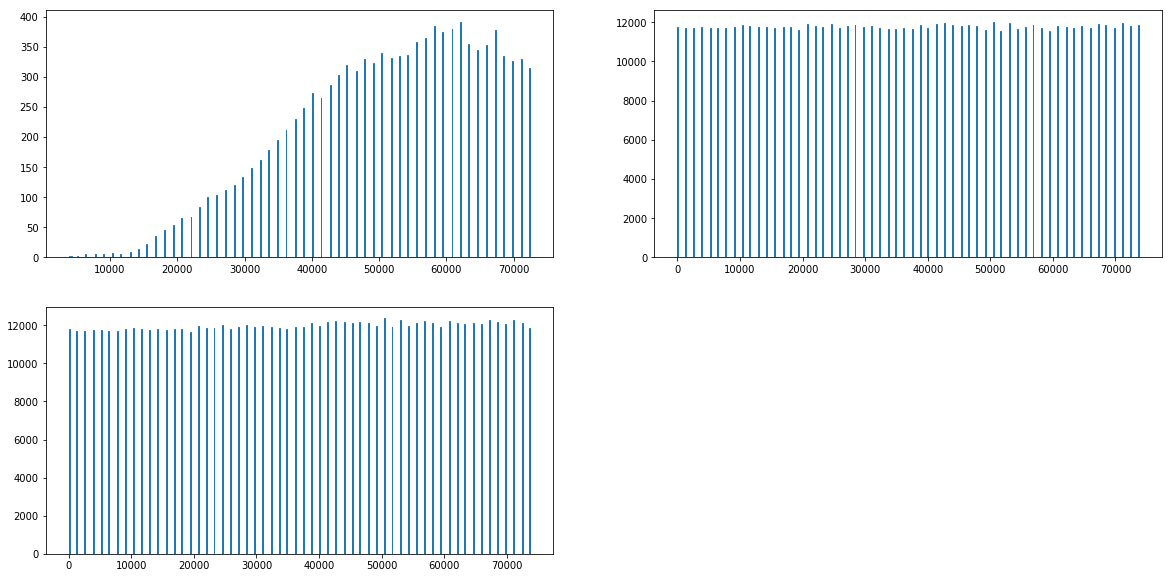

In [11]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

Интересно, что слайсы по z практически на одинаковом расстоянии. Посмотрим, что это за расстояние

In [12]:
np.array(sorted(np.unique(first.Z)))

array([    0.    ,  1293.    ,  2586.    ,  3879.    ,  4154.8867,
        4158.168 ,  5172.    ,  6465.    ,  7758.    ,  9051.    ,
        9247.697 , 10344.    , 10518.494 , 11637.    , 12930.    ,
       14223.    , 15516.    , 16809.    , 16886.393 , 18102.    ,
       19395.    , 19432.521 , 20688.    , 20702.314 , 20707.764 ,
       21977.375 , 21981.    , 23274.    , 24521.258 , 24525.889 ,
       24567.    , 25860.    , 27069.27  , 27153.    , 28446.    ,
       29739.    , 31032.    , 32325.    , 33618.    , 34911.    ,
       35979.586 , 36204.    , 37497.    , 38790.    , 40083.    ,
       41376.    , 42669.    , 43962.    , 45255.    , 46548.    ,
       47841.    , 49134.    , 50427.    , 51720.    , 53013.    ,
       54306.    , 55599.    , 56892.    , 58185.    , 59478.    ,
       60771.    , 62064.    , 63357.    , 64650.    , 65943.    ,
       67236.    , 68529.    , 69822.    , 71115.    , 72408.    ,
       73701.    ], dtype=float32)

Оказывается, что это расстояние 1293

# Группировка на пары

На семинаре мы обсуждали как группировать на пары, поэтому давайте провернём здесь этот номер (код выше)


In [16]:
train = []
for file in glob.glob('hdf5-3/open*.h5')[:5]:
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.97s/it]


In [17]:
train.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,data_ind,event_id,signal,dTX,dTY,dX,dY,dZ
0,-86.840851,-94.468147,92.664032,123.360336,47257.558594,47264.585938,11238.640625,11231.140625,5172.000000,5426.527344,261,183825.0,1.0,7.627296,-30.696304,-7.027344,7.500000,-254.527344
1,-94.468147,-89.869354,123.360336,99.934273,47264.585938,47168.984375,11231.140625,11332.085938,5426.527344,6465.000000,261,183825.0,1.0,-4.598793,23.426064,95.601562,-100.945312,-1038.472656
2,-94.468147,339.412476,123.360336,69.291908,47264.585938,47322.609375,11231.140625,11128.431641,5426.527344,6465.000000,261,183825.0,1.0,-433.880615,54.068428,-58.023438,102.708984,-1038.472656
3,-94.468147,275.844818,123.360336,159.851212,47264.585938,46879.843750,11231.140625,11431.775391,5426.527344,6465.000000,261,183825.0,1.0,-370.312958,-36.490875,384.742188,-200.634766,-1038.472656
4,-89.869354,-70.092018,99.934273,84.584602,47168.984375,47085.210938,11332.085938,11426.468750,6465.000000,7758.000000,261,183825.0,1.0,-19.777336,15.349670,83.773438,-94.382812,-1293.000000


# Построение модельки

In [18]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [19]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [20]:
param_grid = {
        'n_estimators':[20], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8), 
                   param_grid=param_grid, n_jobs=1,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7)

In [21]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=15, n_estimators=20 ...................................
[CV]  max_depth=15, n_estimators=20, score=0.925252041941742, total= 9.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.7min remaining:    0.0s


[CV] max_depth=15, n_estimators=20 ...................................
[CV]  max_depth=15, n_estimators=20, score=0.9244948073082518, total= 9.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 19.1min remaining:    0.0s


[CV] max_depth=15, n_estimators=20 ...................................
[CV]  max_depth=15, n_estimators=20, score=0.9240206269830723, total= 9.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20], 'max_depth': [15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=7)

In [95]:
clf.best_estimator_

XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=20, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8)

In [96]:
xgb_class = XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8)

# Предсказание

In [88]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.89s/it]


In [98]:
xgb_class.fit(X_train, y_train)
probas = xgb_class.predict(X_test)

In [99]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [100]:
agg.shape

(7698899, 1)

In [101]:
agg.head()

,signal
id,
0,0.051291
1,0.005008
2,0.098428
3,0.125704
4,0.009040


In [102]:
agg.to_csv('submit2.csv', index=True)